# Cats and Dogs CNN - SOFTMAX

**Description:** Classify cats and dogs with a simple Convolutional Network<br>
                This version is programmed as a multiclass classifier with a softmax function in last layer <br>
                 
**Dataset:** Kaggle Dogs vs Cats dataset originally from Microsoft <br>
             Transformed the classifier to Softmax (2 classes) <br>
             The split training/validation is changed to 0.3 (70/30) <br>
             

<a target="_blank" href="https://colab.research.google.com/github/castorgit/DL-course/blob/main/08_CNN_Cats_and_Dogs-Transfer_Learning-softmax.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Rescaling, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

import numpy as np

import sys
sys.stderr = open('err.txt', 'w')

AUGMENTATION = True

I0000 00:00:1737712885.523248   37935 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737712885.564105   37935 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737712885.564165   37935 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737712885.568006   37935 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737712885.568064   37935 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:22:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 

#### **Directories**
Reads the Cats and Dogs dataset and loads in. Creating a PetImages folder with two subfolders Cat and Dog <bbr>
Don't repeat this step as with the files/folders created it may have some issues

In [2]:
# Loading the dataset from microsoft cloud - do it only once
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C
[kagglecatsanddogs_5340.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of kagglecatsanddogs_5340.zip or
        kagglecatsanddogs_5340.zip.zip, and cannot find kagglecatsanddogs_5340.zip.ZIP, period.


#### **Cleaning data**
Just for security we delete some photos that may have the header corrupted.

In [2]:
num_skipped = 0
num_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_images += 1

print(f"Deleted {num_skipped} images.")
print(f"There are {num_images} clean images.")

Deleted 0 images.
There are 23412 clean images.


#### **Preparing the data**

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


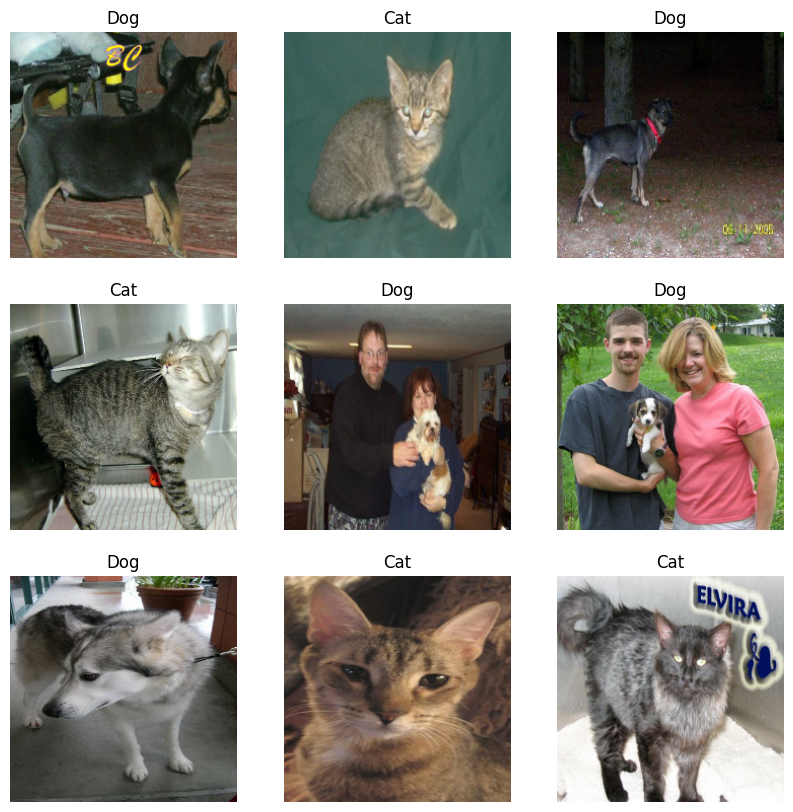

In [3]:
batch_size = 32
img_height = 224
img_width  = 224
train_dir = './PetImages/'
class_names = ['Cat', 'Dog']

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.3,
    subset = 'training',
    label_mode = 'categorical',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.3,
    subset = 'validation',
    label_mode = 'categorical',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        
        
# Optional: Scale pixel values (0-255 to 0-1)
normalization_layer = Rescaling(1./255)

train_dataset        = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset   = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

#### **Network Architecture Definition**

In [4]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(    
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

base_model.trainable = False

inputs = Input(shape=(img_height, img_width, 3))
    
x = base_model(inputs)

# New layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)
    
model = Model(inputs=[inputs], outputs=output)

model.summary()
model.compile(loss='categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001), metrics=['acc'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,306 (76.64 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [5]:
history = model.fit(
      train_dataset,
      epochs=10,
      validation_data=validation_dataset)


Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - acc: 0.7826 - loss: 0.4502 - val_acc: 0.8615 - val_loss: 0.3050
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - acc: 0.8875 - loss: 0.2529 - val_acc: 0.9032 - val_loss: 0.2307
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - acc: 0.9002 - loss: 0.2325 - val_acc: 0.8887 - val_loss: 0.2562
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - acc: 0.9043 - loss: 0.2168 - val_acc: 0.8657 - val_loss: 0.3114
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - acc: 0.9075 - loss: 0.2166 - val_acc: 0.9033 - val_loss: 0.2208
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - acc: 0.9103 - loss: 0.2054 - val_acc: 0.9062 - val_loss: 0.2177
Epoch 7/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - acc: 0.9094 - loss: 0.2025 - val_acc: 0.9057 - val_loss: 0.2187
Epoch 8/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - acc: 0.9168 - loss: 0.1919 - val_acc: 0.8982 - val_loss: 0.2327
Epoch 9/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 

#### **Evaluate the Results**

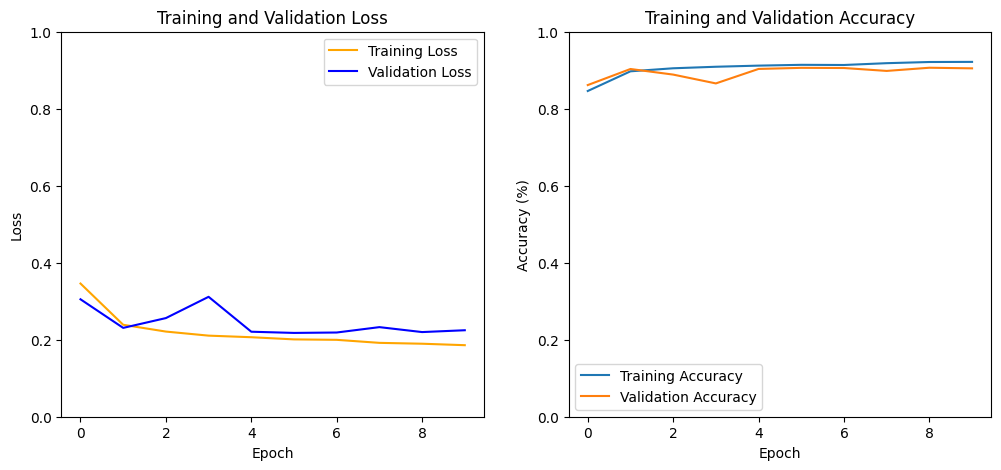

In [6]:
# Plot training loss, accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


#### **Generate Confusion Matrix**

In [7]:
# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # True labels 
    preds = model.predict(images, verbose=0)  # Model predictions
#    y_pred.extend((preds > 0.5).astype(int))   This is for binary
    y_pred.extend(np.argmax(preds, axis = 1))

y_true = np.argmax(y_true, axis = 1)
y_pred = np.array(y_pred)

print(y_true.shape, y_pred.shape)

(7023,) (7023,)


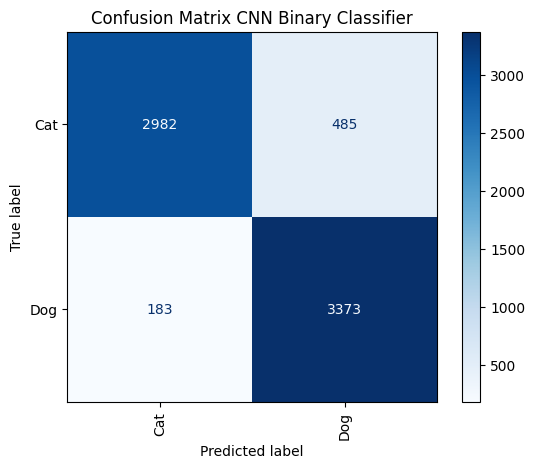

In [8]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix CNN Binary Classifier")
plt.show()

In [9]:
# Final accuracy
final_accuracy = history.history['acc'][-1]  # Last epoch training accuracy
final_val_accuracy = history.history['val_acc'][-1] 

print(f"Final Training Accuracy: {final_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")

Final Training Accuracy: 0.9216452240943909
Final Validation Accuracy: 0.9048839807510376


In [10]:
import session_info
session_info.show(html=False)

-----
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
sklearn             1.5.2
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-01-24 11:07
